# Improving a DAN trained on clean data with ASR Confidences

The following notebook reads (clean and ASR) QuizBowl data using a file called "dataset.py" and builds a Deep Averaging Network that leverages confidences to improve over the baseline.

## Dependencies - helpful Python tools, PyTorch

In [1]:
#general python
import json
from sklearn.feature_extraction.text import CountVectorizer
from tqdm import tqdm_notebook
import numpy as np
import string
from sklearn.metrics import accuracy_score
import time
from typing import List, Optional, Dict
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook 
from collections import defaultdict

#torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

#torchtext.  Dataset is a custom file for handling QuizBowl data
from dataset import QuizBowl
from torchtext.data.field import Field
from torchtext.data.iterator import Iterator

#code to read-in torchtext data and optional way to refresh those modules
import dataset
import dataset_confidence
#import importlib
#importlib.reload(dataset_confidence)

ModuleNotFoundError: No module named 'tqdm'

## Model

The following section contains code that designs a Deep Averaging Network, variations thereupon in ascending order of complexity, and classes that learn confidence functions

In [ ]:
class LogRegression(nn.Module):
    def __init__(self, embedding_dim, 
                 h1_dim, text_field, answer_size):
        
        super(LogRegression, self).__init__()
        text_vocab = text_field.vocab
        self.text_vocab_size = len(text_vocab)
        text_pad_idx = text_vocab.stoi[text_field.pad_token]
        self.text_embeddings = nn.Embedding(self.text_vocab_size, embedding_dim, padding_idx=text_pad_idx)
        self.text_field = text_field

        mean_emb = text_vocab.vectors.mean(0)
        text_vocab.vectors[text_vocab.stoi[text_field.unk_token]] = mean_emb
        self.text_embeddings.weight.data = text_vocab.vectors.cuda()
        
        #freeze the embeddings
        self.text_embeddings.weight.requires_grad = False
        
        self.dropout = nn.Dropout(p=0.265)
        self.classifier = nn.Sequential(
            nn.Linear(embedding_dim, answer_size),
            nn.BatchNorm1d(answer_size),
            nn.Dropout(.15)
        )
        
    def _pool(self, embed, lengths, batch_size):
        return embed.sum(1) / lengths.view(batch_size, -1)
    
    def forward(self, input_: Dict[str, Variable], lengths: Dict, qnums): 
        for key in lengths:
            if not isinstance(lengths[key], Variable):
                lengths[key] = Variable(lengths[key].float(), volatile=not self.training)
                
        if self.text_field is not None:
            text_input = input_['text']
            embed = self.text_embeddings(text_input)
            averaged = self._pool(embed, lengths['text'].float(), text_input.size()[0])
            averaged_dropped = self.dropout(averaged)
            return self.classifier(averaged_dropped)

Relative to the logistic regression above, the DAN adds in a hidden layer of 1000 units towards the end the network

In [122]:
class DAN(nn.Module):
    def __init__(self, embedding_dim, 
                 h1_dim, text_field, answer_size):
        super(DAN, self).__init__()
        
        #initialize the vocab from the text field (passed in from train_iter) and pad
        text_vocab = text_field.vocab
        self.text_vocab_size = len(text_vocab)
        text_pad_idx = text_vocab.stoi[text_field.pad_token]
        
        #run the vocab through Glove Embeddings
        self.text_embeddings = nn.Embedding(self.text_vocab_size, embedding_dim, padding_idx=text_pad_idx)
        self.text_field = text_field
        
        #set the unknown items to the mean embedding and make them cuda()
        mean_emb = text_vocab.vectors.mean(0)
        text_vocab.vectors[text_vocab.stoi[text_field.unk_token]] = mean_emb
        self.text_embeddings.weight.data = text_vocab.vectors.cuda()
        
        #freeze the embeddings
        #self.text_embeddings.weight.requires_grad = False 
        
        #layers used in the network
        self.large_dropout = nn.Dropout(p=0.265)
        self.small_dropout = nn.Dropout(p=0.15)
        self.nonlinear = nn.Sigmoid()
        self.hidden = nn.Linear(embedding_dim, h1_dim)
        self.batch_norm = nn.BatchNorm1d(h1_dim)
        
        #the classifier converts the hidden dimensions into the answers.  
        #It takes batch norm and dropout as well.
        self.classifier = nn.Sequential(
            nn.Linear(h1_dim, answer_size),
            nn.BatchNorm1d(answer_size),
            nn.Dropout(.15)
        )

    def _pool(self, embed, lengths, batch_size):
        return embed.sum(1) / lengths.view(batch_size, -1)
    
    def forward(self, input_: Dict[str, Variable], lengths: Dict, qnums): 
        for key in lengths:
            if not isinstance(lengths[key], Variable):
                lengths[key] = Variable(lengths[key].float(), volatile=not self.training)
        
        #if the text exists, run it through embeddings, pool, dropout, and then run it through a hidden layer
        if self.text_field is not None:
            text_input = input_['text']
            embed = self.text_embeddings(text_input)
            averaged = self._pool(embed, lengths['text'].float(), text_input.size()[0])
            averaged_dropped = self.small_dropout(averaged)
            hidden_layer = self.hidden(averaged_dropped)
            batchnormed_dropped = self.large_dropout(self.batch_norm(hidden_layer))
            nonlinear = self.nonlinear(batchnormed_dropped)
            return self.classifier(nonlinear )

In [ ]:
class RNN(nn.Module):
    def __init__(self, embedding_dim, 
                 h1_dim, text_field, answer_size):
        super(RNN, self).__init__()
        
        #initialize the vocab from the text field (passed in from train_iter) and pad
        text_vocab = text_field.vocab
        self.text_vocab_size = len(text_vocab)
        text_pad_idx = text_vocab.stoi[text_field.pad_token]
        
        #run the vocab through Glove Embeddings
        self.text_embeddings = nn.Embedding(self.text_vocab_size, embedding_dim, padding_idx=text_pad_idx)
        self.text_field = text_field
        
        #set the unknown items to the mean embedding and make them cuda()
        mean_emb = text_vocab.vectors.mean(0)
        text_vocab.vectors[text_vocab.stoi[text_field.unk_token]] = mean_emb
        self.text_embeddings.weight.data = text_vocab.vectors.cuda()
        
        #freeze the embeddings
        #self.text_embeddings.weight.requires_grad = False 
        
        #layers used in the network
        self.large_dropout = nn.Dropout(p=0.265)
        self.small_dropout = nn.Dropout(p=0.15)
        self.nonlinear = nn.Sigmoid()
        
        self.hidden = self.init_hidden()
        self.rnn = nn.RNN(embedding_dim, h1_dim)
        self.batch_norm = nn.BatchNorm1d(h1_dim)
        
        #the classifier converts the hidden dimensions into the answers.  
        #It takes batch norm and dropout as well.
        self.classifier = nn.Sequential(
            nn.Linear(h1_dim, answer_size),
            nn.BatchNorm1d(answer_size),
            nn.Dropout(.15)
        )

    def init_hidden(self):
        """
        Return variables that we can use as h_0 and c_0. 
        """
        return (Variable(torch.zeros(1, 1, self.hidden_dim)),
                Variable(torch.zeros(1, 1, self.hidden_dim)))
    
    def forward(self, input_: Dict[str, Variable], lengths: Dict, qnums): 
        for key in lengths:
            if not isinstance(lengths[key], Variable):
                lengths[key] = Variable(lengths[key].float(), volatile=not self.training)
        
        #if the text exists, run it through embeddings, pool, dropout, and then run it through a hidden layer
        if self.text_field is not None:
            text_input = input_['text']
            embed = self.text_embeddings(text_input)
            x, self.hidden = self.rnn(x.view(len(x), 1, -1), self.hidden)
            nonlinear = self.nonlinear(x)
            return self.classifier(x)
            
            #averaged = self._pool(embed, lengths['text'].float(), text_input.size()[0])
            #averaged_dropped = self.small_dropout(averaged)
            #hidden_layer = self.hidden(averaged_dropped)
            #batchnormed_dropped = self.large_dropout(self.batch_norm(hidden_layer))
            

The below Confidence Learner is used to learn mappings from embeddings and confidences to a single value.  This is used in the modified DAN that follows. The simple confidence learner simply passes on the confidence.

In [2]:
class ConfidenceLearner(nn.Module):
    def __init__(self, embeddings_dim, confidences_dim):
        super(ConfidenceLearner, self).__init__()
        self.transform = nn.Linear((embeddings_dim + confidences_dim), 1)
    
    def forward(self, embeds, confs):
        concat = torch.cat((embeds, confs), -1)
        data = torch.sigmoid(self.transform(concat))
        return data
    
    
#train with SimpleConfidenceLearner.  Then freeze embeddings and train ConfidenceLearner.
#loop through each parameter and set weights equal to it

In [21]:
class SimpleConfidenceLearner(nn.Module):
    def __init__(self, embeddings_dim, confidences_dim):
        #does nothing
        super(SimpleConfidenceLearner, self).__init__()
        pass
    
    def forward(self, embeds, confs):
        return confs.unsqueeze(2)

This DAN ingests a "confidence" field from TorchText, which is a vector of confidences in range 0-1. Both init and forward are adjusted to accomodate this.

In [19]:
class DAN_Confidences(nn.Module):
    def __init__(self, embedding_dim, 
                 h1_dim, text_field, answer_size):
        super(DAN_Confidences, self).__init__()
        text_vocab = text_field.vocab
        self.text_vocab_size = len(text_vocab)
        text_pad_idx = text_vocab.stoi[text_field.pad_token]
        self.text_embeddings = nn.Embedding(self.text_vocab_size, embedding_dim, padding_idx=text_pad_idx)
        self.text_field = text_field

        mean_emb = text_vocab.vectors.mean(0)
        text_vocab.vectors[text_vocab.stoi[text_field.unk_token]] = mean_emb
        self.text_embeddings.weight.data = text_vocab.vectors.cuda()
        self.text_embeddings.weight.requires_grad = False
        #freeze the embeddings
        
        #confidences are learned from word_embeddings and respective word_confidence
        self.confidences = SimpleConfidenceLearner(embedding_dim, 1)
        
        #layers used in the network
        self.large_dropout = nn.Dropout(p=0.265)
        self.small_dropout = nn.Dropout(p=0.15)
        
        self.nonlinear = nn.Sigmoid()
        self.hidden = nn.Linear(embedding_dim, h1_dim)
        self.batch_norm = nn.BatchNorm1d(h1_dim)
        
        self.classifier = nn.Sequential(
            nn.Linear(h1_dim, answer_size),  #make this h1_dim+1 when appeneded
            nn.BatchNorm1d(answer_size),
            nn.Dropout(.15)
        )
        
    def _pool(self, embed, lengths, batch_size):
        return embed.sum(1) / lengths.view(batch_size, -1)
    
    def forward(self, input_: Dict[str, Variable], lengths: Dict, qnums, confidences): 
        for key in lengths:
            if not isinstance(lengths[key], Variable):
                lengths[key] = Variable(lengths[key].float(), volatile=not self.training)
        
        if self.text_field is not None:
            text_input = input_['text']
            embed = self.text_embeddings(text_input)
            confidences = Variable(confidences).cuda()
            confidences = self.confidences(embed, confidences)
            multiplied = embed * confidences
            averaged = self._pool(multiplied, lengths['text'].float(), text_input.size()[0])
            averaged_dropped = self.small_dropout(averaged)
            hidden_layer = self.hidden(averaged_dropped)
            batchnormed_dropped = self.large_dropout(self.batch_norm(hidden_layer))
            nonlinear = self.nonlinear(batchnormed_dropped)
            return self.classifier(nonlinear )
        
        
        #layer.weights.data[:, -1] = pretrainedweights
        #layer.bias.data[: -1]

In [ ]:
class DAN_Confidences_Softmax(nn.Module):
    def __init__(self, embedding_dim, 
                 h1_dim, text_field, answer_size):
        super(DAN_Confidences_Softmax, self).__init__()
        text_vocab = text_field.vocab
        self.text_vocab_size = len(text_vocab)
        text_pad_idx = text_vocab.stoi[text_field.pad_token]
        self.text_embeddings = nn.Embedding(self.text_vocab_size, embedding_dim, padding_idx=text_pad_idx)
        self.text_field = text_field

        mean_emb = text_vocab.vectors.mean(0)
        text_vocab.vectors[text_vocab.stoi[text_field.unk_token]] = mean_emb
        self.text_embeddings.weight.data = text_vocab.vectors.cuda()
        #self.text_embeddings.weight.requires_grad = False
        #freeze the embeddings
        
        #layers used in the network
        self.large_dropout = nn.Dropout(p=0.265)
        self.small_dropout = nn.Dropout(p=0.15)
        
        self.nonlinear = nn.Sigmoid()
        self.hidden = nn.Linear(embedding_dim, h1_dim)
        self.batch_norm = nn.BatchNorm1d(h1_dim)
        
        self.classifier = nn.Sequential(
            nn.Linear(h1_dim+1, answer_size),  #make this h1_dim+1 when appeneded
            nn.BatchNorm1d(answer_size),
            nn.Dropout(.15)
        )
        
    def _pool(self, embed, lengths, batch_size):
        return embed.sum(1) / lengths.view(batch_size, -1)
    
    def forward(self, input_: Dict[str, Variable], lengths: Dict, qnums, confidences): 
        for key in lengths:
            if not isinstance(lengths[key], Variable):
                lengths[key] = Variable(lengths[key].float(), volatile=not self.training)
        
        if self.text_field is not None:
            text_input = input_['text']
            embed = self.text_embeddings(text_input)
            #do this elsewhere
            confidences = Variable(confidences).cuda()                   
            averaged = self._pool(embed, lengths['text'].float(), text_input.size()[0])
            averaged_dropped = self.small_dropout(averaged)
            hidden_layer = self.hidden(averaged_dropped)  
            batchnorm_dropped = self.large_dropout(self.batch_norm(hidden_layer))
            nonlinear = self.nonlinear(batchnorm_dropped)
            expanded = torch.cat((nonlinear,confidences.mean(dim=1).unsqueeze(-1)), 1)
            return self.classifier(expanded)

In [ ]:
#TODO
# pretrainweights = model.classifier[0].weights.data
# load from existing model

#in the new model, in __init__
#layer.weights.data[:, :-1] = pretrainedweights
#layer.bias.data[:-1] #this is vector

#for average, just give it existing weights

In [42]:
class DAN_WeightedMean(nn.Module):
    def __init__(self, embedding_dim, 
                 h1_dim, text_field, answer_size):
        super(DAN_WeightedMean, self).__init__()
        text_vocab = text_field.vocab
        self.text_vocab_size = len(text_vocab)
        text_pad_idx = text_vocab.stoi[text_field.pad_token]
        self.text_embeddings = nn.Embedding(self.text_vocab_size, embedding_dim, padding_idx=text_pad_idx)
        self.text_field = text_field

        mean_emb = text_vocab.vectors.mean(0)
        text_vocab.vectors[text_vocab.stoi[text_field.unk_token]] = mean_emb
        self.text_embeddings.weight.data = text_vocab.vectors.cuda()
        self.text_embeddings.weight.requires_grad = False
        #freeze the embeddings
        
        #layers used in the network
        self.large_dropout = nn.Dropout(p=0.265)
        self.small_dropout = nn.Dropout(p=0.15)
        
        self.nonlinear = nn.Sigmoid()
        self.hidden = nn.Linear(embedding_dim, h1_dim)
        self.batch_norm = nn.BatchNorm1d(h1_dim)
        
        #self.confidences = ConfidenceLearner(embedding_dim, 1) # ADDED IN FOR VARIATION
        
        self.classifier = nn.Sequential(
            nn.Linear(h1_dim, answer_size),
            nn.BatchNorm1d(answer_size),
            nn.Dropout(.15)
        )
        
    def _pool(self,  embed, lengths, confidences):
        embed = embed * confidences.unsqueeze(2).expand_as(embed) 
        embed = embed.sum(1)
        return embed / confidences.sum(dim = 1).unsqueeze(1).expand_as(embed)
                    
        #for learning variation
              #pass in output of CONFIDENCE LEARNER into POOOl
              #dimensions will be the same, just learning new value for confidence
    
    def forward(self, input_: Dict[str, Variable], lengths: Dict, qnums, confidences): 
        for key in lengths:
            if not isinstance(lengths[key], Variable):
                lengths[key] = Variable(lengths[key].float(), volatile=not self.training)
                
        if self.text_field is not None:
            text_input = input_['text']
            embed = self.text_embeddings(text_input)
            confidences = Variable(confidences).cuda() 
            #confidences = self.confidences(embed, confidences).squeeze() #ADDED IN FOR VARIATION
            averaged = self._pool(embed, lengths['text'].float(), confidences)
            averaged_dropped = self.small_dropout(averaged)
            hidden_layer = self.hidden(averaged_dropped)
            batchnorm_dropped = self.large_dropout(self.batch_norm(hidden_layer))
            nonlinear = self.nonlinear(batchnorm_dropped)
            return self.classifier(batchnorm_dropped)

## Data and Training

The following code uses a custom class from dataset.py to read in the data into TorchText, which allows for easy batching in PyTorch.  The second cell extracts the vocab and answers for this particular model, to use as mappings for other models.

In [107]:
import importlib
importlib.reload(dataset)
train_iter, val_iter, dev_iter = dataset.QuizBowl.iters(
            batch_size=512,
            lower= True,
            use_wiki=False,  #irrelevant
            n_wiki_sentences=5, #irrelevant 
            replace_title_mentions='',
            combined_ngrams=True,
            unigrams=True, 
            bigrams=False, #irrelevant 
            trigrams=False, #irrelevant 
            combined_max_vocab_size=300000,
            unigram_max_vocab_size= None, 
            bigram_max_vocab_size=50000, #irrelevant 
            trigram_max_vocab_size=50000 #irrelevant 
        )

In [108]:
fields: Dict[str, Field] = train_iter.dataset.fields
page_field = fields['page']
clean_answer_mappings = page_field.vocab.stoi
clean_vocab_mappings = fields['text'].vocab.stoi

### OPTIONAL.  For verifying clean/clean

In [ ]:
import importlib
importlib.reload(dataset)
train_iter_buzzer, val_iter_buzzer, dev_iter_buzzer_same = dataset.QuizBowl.iters(
            batch_size=512,
            lower= True,
            use_wiki=False,  #irrelevant
            n_wiki_sentences=5, #irrelevant 
            replace_title_mentions='',
            combined_ngrams=True,
            unigrams=True, 
            bigrams=False, #irrelevant 
            trigrams=False, #irrelevant 
            combined_max_vocab_size=300000,
            unigram_max_vocab_size= None, 
            bigram_max_vocab_size=50000, #irrelevant 
            trigram_max_vocab_size=50000 #irrelevant 
        )

In [ ]:
fields: Dict[str, Field] = train_iter_buzzer.dataset.fields
page_field = fields['page']
buzz_answer_mappings = page_field.vocab.stoi
buzz_vocab_mappings = fields['text'].vocab.stoi

This section does the exact same as above, only for ASR data (rather than clean data).  Dataset_confidence is a modified version of dataset that ingests a "confidence" field, has different formatting for the text (tupples rather than full sentences), and does not shuffle as data has been shuffled up front. 

In [32]:
import importlib
importlib.reload(dataset_confidence)
train_iter_asr, val_iter_asr, dev_iter_asr = dataset_confidence.QuizBowl.iters(
            batch_size=512,
            lower= True,
            use_wiki=False,  #irrelevant
            n_wiki_sentences=5, #irrelevant 
            replace_title_mentions='',
            combined_ngrams=True,
            unigrams=True, 
            bigrams=False, #irrelevant 
            trigrams=False, #irrelevant 
            combined_max_vocab_size=300000,
            unigram_max_vocab_size= None, 
            bigram_max_vocab_size=50000, #irrelevant 
            trigram_max_vocab_size=50000 #irrelevant 
        )

In [110]:
fields: Dict[str, Field] = train_iter_asr.dataset.fields
page_field_asr = fields['page']
asr_answer_mappings = page_field_asr.vocab.stoi
asr_vocab_mappings = fields['text'].vocab.stoi

### Generate Dictionaries

The following code generates default dictionaries that converts VOCAB and ANSWERS from ASR to Clean torch datatsets and vice versa.  Code redundant for visibility.

In [111]:
clean_to_asr = defaultdict(int)
count = 0
for key, vals in clean_answer_mappings.items():
    if key in asr_answer_mappings.keys():
        clean_to_asr[vals] = asr_answer_mappings[key]
clean_to_asr[0] = 0 #many possible options for 0, so ensure that this gets mapped to 0

asr_to_clean = defaultdict(int)
for key, vals in asr_answer_mappings.items():
    if key in clean_answer_mappings.keys():
        asr_to_clean[vals] = clean_answer_mappings[key]     
#asr_to_clean = {v: k for k, v in clean_to_asr.items()}

In [112]:
clean_to_asr_vocab = defaultdict(int)
count = 0
for key, vals in clean_vocab_mappings.items():
    if key in asr_vocab_mappings.keys():
        clean_to_asr_vocab[vals] = asr_vocab_mappings[key]
clean_to_asr_vocab[0] = 0

asr_to_clean_vocab = defaultdict(int)
for key, vals in asr_vocab_mappings.items():
    if key in clean_vocab_mappings.keys():
        asr_to_clean_vocab[vals] = clean_vocab_mappings[key]    

In [ ]:
### OPTIONAL FOR CLEAN

In [ ]:
clean_to_buzz = defaultdict(int)
count = 0
for key, vals in clean_answer_mappings.items():
    if key in buzz_answer_mappings.keys():
        clean_to_buzz[vals] = buzz_answer_mappings[key]
clean_to_buzz[0] = 0 #many possible options for 0, so ensure that this gets mapped to 0

buzz_to_clean = defaultdict(int)
for key, vals in buzz_answer_mappings.items():
    if key in clean_answer_mappings.keys():
        buzz_to_clean[vals] = clean_answer_mappings[key]     
#asr_to_clean = {v: k for k, v in clean_to_asr.items()}

In [ ]:
clean_to_buzz_vocab = defaultdict(int)
count = 0
for key, vals in clean_vocab_mappings.items():
    if key in buzz_vocab_mappings.keys():
        clean_to_buzz_vocab[vals] = buzz_vocab_mappings[key]
clean_to_buzz_vocab[0] = 0

buzz_to_clean_vocab = defaultdict(int)
for key, vals in buzz_vocab_mappings.items():
    if key in clean_vocab_mappings.keys():
        buzz_to_clean_vocab[vals] = clean_vocab_mappings[key]    

### Specify Running Conditions

The following code loops through batches, runs them through the network, calculates loss, and backpropogates.  It can both train and simply run through the network (for testing).  The code marked as "IMPORTANT" passes the code through the ASR_to_Clean dictionary that is necessary for train/testing to work across datasets.

In [128]:
def run_epoch(iterator: Iterator):
        is_train = iterator.train
        batch_accuracies = []
        batch_losses = []
        epoch_start = time.time()
        for batch in iterator:
            input_dict = {}
            lengths_dict = {}
            if hasattr(batch, 'text'):
                text, lengths = batch.text
                
                #IMPORTANT.  ADJUSTS BETWEEN DATASETS
                text = text.data.cpu().numpy().tolist()
                for i, group in enumerate(text):
                    #print(group)
                    for j, item in enumerate(group):
                        text[i][j]=asr_to_clean_vocab[item]
                text = Variable(torch.from_numpy(np.asarray(text))).cuda()
  
                input_dict['text'] = text
                lengths_dict['text'] = lengths
            page = batch.page
            qnums = batch.qnum.cuda()

            if is_train:
                model.zero_grad()

            out = model(input_dict, lengths_dict, qnums)
            _, preds = torch.max(out, 1)
            
           #IMPORTANT.  ADJUSTS BETWEEN DATASETS
            page = page.data.cpu().numpy()
            page = [asr_to_clean[i] for i in page]
            page = Variable(torch.from_numpy(np.asarray(page))).cuda()
            
            
            accuracy = torch.mean(torch.eq(preds, page).float()).data[0]
            batch_loss = loss_function(out, page)
            if is_train:
                batch_loss.backward()
                torch.nn.utils.clip_grad_norm(model.parameters(), .25)
                optimizer.step()

            batch_accuracies.append(accuracy)
            batch_losses.append(batch_loss.data[0])

        epoch_end = time.time()

        return np.mean(batch_accuracies), np.mean(batch_losses), epoch_end - epoch_start

The following is a variation on the base version that handles confidences: confidences = batch.confidence.  If confidences are not present, it creates a tensor that matches the size of the text, and populates it with all 1s.  

In [11]:
def run_epoch_confidences(iterator: Iterator):
        is_train = iterator.train
        batch_accuracies = []
        batch_losses = []
        epoch_start = time.time()
        for batch in iterator:
            input_dict = {}
            lengths_dict = {}
            if hasattr(batch, 'text'):
                text, lengths = batch.text
                
                #IMPORTANT.  ADJUSTS BETWEEN DATASETS
#                 text = text.data.cpu().numpy().tolist()
#                 for i, group in enumerate(text):
#                     for j, item in enumerate(group):
#                         text[i][j]=asr_to_clean_vocab[item]
#                 text = Variable(torch.from_numpy(np.asarray(text))).cuda()
                
                input_dict['text'] = text
                lengths_dict['text'] = lengths

            page = batch.page
            
            #IMPORTANT.  ADJUSTS BETWEEN DATASETS
#             page = page.data.cpu().numpy()
#             page = [asr_to_clean[i] for i in page]
#             page = Variable(torch.from_numpy(np.asarray(page))).cuda()
            
            
            qnums = batch.qnum.cuda()
            #if hasattr(batch, 'confidence'):
            confidences = batch.confidence
            #else:
            #    confidences = torch.FloatTensor(batch.text[0].shape).fill_(1)
                #print ("Missing confidences")
                #raise
            
            if is_train:
                model.zero_grad()

            out = model(input_dict, lengths_dict, qnums, confidences,)
            _, preds = torch.max(out, 1)
            accuracy = torch.mean(torch.eq(preds, page).float()).data[0]
            batch_loss = loss_function(out, page)
            if is_train:
                batch_loss.backward()
                torch.nn.utils.clip_grad_norm(model.parameters(), .25)
                optimizer.step()

            batch_accuracies.append(accuracy)
            batch_losses.append(batch_loss.data[0])

        epoch_end = time.time()

        return np.mean(batch_accuracies), np.mean(batch_losses), epoch_end - epoch_start

## Initialization

In [43]:
#Set the dimensions and epochs for model
EMBEDDING_DIM = 300 
HIDDEN_DIM = 1000
EPOCH = 25

#extract fields to determine vocabulary size of answers
#UPDATE THIS BETWEEN CLEAN AND ASR
fields: Dict[str, Field] = train_iter_asr.dataset.fields
page_field = fields['page']
ANSWER_SIZE = len(page_field.vocab.stoi)
 
model =DAN_WeightedMean(EMBEDDING_DIM,
             HIDDEN_DIM,
             fields['text'], 
             ANSWER_SIZE)
model = model.cuda()

loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()))

In [54]:
#variables to generate graphs, save best model
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
best_accuracy = 0.
last_accuracy = 0

for i in tqdm_notebook(range(EPOCH)):  
    #train
    model.train()
    train_acc, train_loss, train_time = run_epoch_confidences(train_iter_asr)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    
    #validate
    model.eval()
    val_acc, val_loss, val_time = run_epoch_confidences(val_iter_asr)    
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    #if val_acc < last_accuracy:
        #break
        #raise ("Stopping early at Epoch ", i)
    
    if val_acc > best_accuracy:
        best_accuracy = val_acc
        #torch.save(model.state_dict(), './cleanmodel.pth')
        
    last_accuracy = val_acc

HBox(children=(IntProgress(value=0, max=25), HTML(value='')))

/cliphomes/dpeskov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: generator 'Iterator.__iter__' raised StopIteration
  


## Results and Graphs

In [55]:
#Test on final.  Dev is taken from the ASR data, and not from Clean data, 
#so this can be dramatically lower than validation accuracy
model.eval()
test_acc, test_loss, test_time = run_epoch_confidences(dev_iter_asr)
test_acc

/cliphomes/dpeskov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: generator 'Iterator.__iter__' raised StopIteration
  


0.1617440951722009

In [52]:
val_accuracies

[0.11938138610937378,
 0.1202295304022052,
 0.12049586562947794,
 0.1197175019505349,
 0.1201708929782564,
 0.12027391960675066,
 0.11975714174861257,
 0.1187409394505349,
 0.12127587368542497,
 0.12132501229643822,
 0.1210586770691655,
 0.12231582301584157,
 0.12061003561724316,
 0.1221826554022052,
 0.12254251878369939,
 0.12351908128369939,
 0.12312432784925807,
 0.12261704863472418,
 0.12291188063946637,
 0.11880432645028288,
 0.12190682136199692,
 0.12249812957915393,
 0.1220938769931143,
 0.12054025483402339,
 0.12143753807653081]

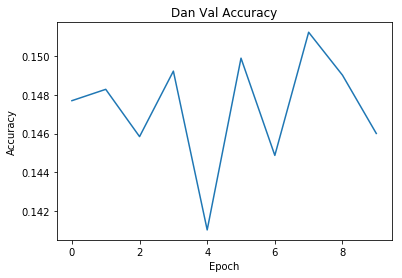

In [17]:
plt.title("Dan Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(val_accuracies)

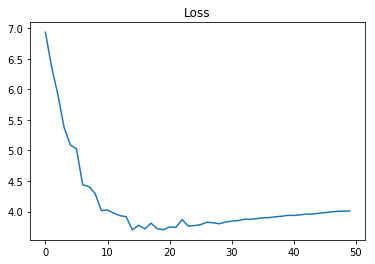

In [132]:
plt.title("Loss")
plt.plot(val_losses)